# __Unit Roots, Cointegration, and Error-Correction Models (Python)__

<br>

Finance 6470: Derivatives Markets <br>
Tyler J. Brough <br>
Last Update: March 7, 2019 <br>
<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Unit Roots and Stationarity 

A simple starting model for efficient log-prices of assets is the ___Random Walk with Drift___ model:


$$
y_{t} = \mu + y_{t-1} + \epsilon_{t}, \quad \quad \epsilon \sim N(0, \sigma_{\epsilon}^{2})
$$

with something like $y_{t} = \ln{(p_{t})}$ with $p_{t}$ a transaction price observed in some market. The expected value of this process is: 

$$
E(y_{t}) = \mu + y_{t-1}
$$

<br>

To get the variance it is helpful to solve recursively as follows, assuming $y_{0} = 0$ for simplicity:

$$
y_{t} = t \mu + \sum\limits_{i=0}^{t} \epsilon_{t-i}
$$

<br>

We can now state the variance of the process as:

$$
Var(y_{t}) = \sum\limits_{i=0}^{t} Var(\epsilon_{t-i}) = Var(\epsilon_{t}) + Var(\epsilon_{t-1}) + \cdots + Var(\epsilon_{0}) = t \sigma_{\epsilon}^{2}
$$

<br>

From this it is easy to see that this is an explosive process as the variance is proportional to time. This translates to the value of the process at any time $t$ being unpredictable based on the information known up to that time ($I_{t-1}$). This is a good starting place for a model of informationally efficient prices as the definition of such is one that incorporates all available information up to that point in time. 

<br>

__NB:__ Samuelson's paper: [Proof That Properly Anticipated Prices Fluctuate Randomly](https://www.gyc.com.sg/files/p_samuelson-proof.pdf)

<br>

We can simulate this process as follows (setting $\mu = 0$ for convenience):

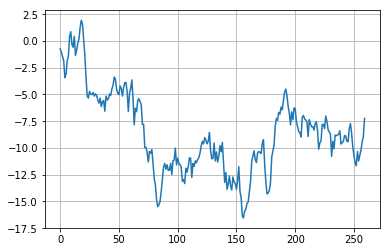

In [2]:
y = pd.Series(np.cumsum(np.random.normal(size=52*5)))
y.plot(grid=True)

### Weak Stationarity

In the time series literature a process is known as [weakly stationary](https://en.wikipedia.org/wiki/Stationary_process#Weak_or_wide-sense_stationarity) if the mean and autocovariance are not time varying. 

<br>

A few notes:

* Clearly the random walk process is __NOT__ weakly stationary.
* A weakly stationary time series process will exhibit mean reversion
* Mean reversion in a time series can be such that there is some predictibility in the process

<br>

It makes sense that informationally efficient prices should behave as a random walk model (with possible other extensions).


<br>
<br>

The random walk model is a special case of the AR(1) model:

$$
y_{t} = \phi y_{t-1} + \epsilon_{t}
$$

<br>

It won't be shown here, but a technical requirement for the AR(1) model to be weakly stationary is $|\phi| < 1$. For the random walk model $\phi = 1$, thus the alternative name ___unit root___.

<br>
<br>

### Some Notation

A random walk model is also known as a unit-root non-stationary process. In the literature this is often denoted as $y_{t} \sim I(1)$. We state this as: "_the process $y_{t}$ is_ ___integrated of order one___."

<br>
<br>

We can tranform and $I(1)$ process to a stationary process by ___first differencing___ the process like so:

$$
\begin{aligned}
y_{t} - y_{t-1} &= y_{t-1} - y_{t-1} + \epsilon_{t} \\
y_{t} - y_{t-1} &= \epsilon_{t} \\
\Delta y_{t}    &= \epsilon_{t}
\end{aligned}
$$

<br>
<br>

In this case we can denote that $\Delta y_{t}$ is now weakly stationary with the notation $\Delta y_{t} \sim I(0)$, i.e. "$\Delta y_{t}$ _is_ ___integrated of order zero.___"

## Spurious Regression

It is important to understand the properties of unit root processes, because they can be problematic to work with in applying econometrics to finance. 

<br>

For example, there is a well-known problem of ___spurious regression___ when one unit root process is regressed on an independent unit root process:

<br>

$$
y_{t} = \alpha + \beta x_{t} + u_{t}, \quad u_{t} \sim N(0, \sigma_{u}^{2})
$$

<br>

This regression is not valid because the homoscedasticity assumption of the error term is violated (recall that $Var(y_{t}) = t\sigma_{\epsilon}^{2}$)

<br>
<br>

This can be easily demonstrated by a simple Monte Carlo study as follows:

In [3]:
from scipy import stats

In [4]:
M = 10000
N = 52 * 5
betaHat = np.empty(M)
Rsqrd = np.empty(M)

for i in range(M):
    y = np.cumsum(np.random.normal(size=N))
    x = np.cumsum(np.random.normal(size=N))
    reg = stats.linregress(x,y)
    betaHat[i] = reg.slope
    Rsqrd[i] = reg.rvalue ** 2

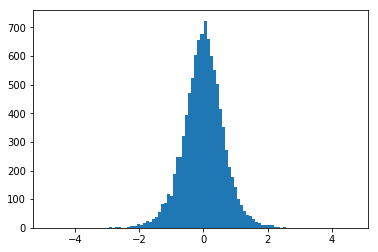

In [5]:
plt.hist(betaHat, bins=100);

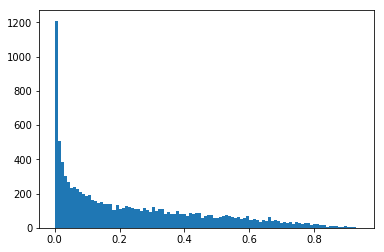

In [6]:
plt.hist(Rsqrd, bins=100);

While the central tendency of sampling distribution appears to be zero, the distribution is extremely wide, so while we will fail to reject the null hypothesis on average we will fail to do so far too often. 

<br>

We can also see from histogram of the $R^{2}$ that there are some extremely high values even though we know that the processes are independent!

<br>

## The Dickey-Fuller Test for Unit Roots

We can test for unit roots in a time series process with the so-called ___Dickey-Fuller Test___, named for the statisticians who invented it. 

<br>

It would seem natural to test the following hypothesis: 

<br>

$$
\begin{aligned}
H_{0}: \phi = 1 \\
H_{a}: \phi \ne 1
\end{aligned}
$$

for the regression: $y_{t} = \phi y_{t-1} + \epsilon_{t}$, but because the model under the null hypothesis leads to spurious regression we cannot conduct this direct test. 

<br>

D-F had the bright idea to transform the model to render it amenable to such testing. We start by subtracting $y_{t-1}$ from both sides:

$$
\begin{aligned}
y_{t} - y_{t-1} &= \phi y_{t-1} - y_{t-1} + \epsilon_{t} \\
\Delta y_{t}    &= (\phi - 1) y_{t-1} + \epsilon_{t} \\
\Delta y_{t}    &= \theta y_{t-1} + \epsilon_{t}
\end{aligned}
$$

<br>

where $\theta = \phi - 1$. With this transformation we can now conduct the test:

$$
\begin{aligned}
H_{0}: \theta = 0 \\
H_{a}: \theta \ne 0
\end{aligned}
$$

<br>

Because $\Delta y_{t} \sim I(0)$ and when $\phi = 1$ it means that $\theta = 0$ this model is now valid under the null hypothesis. We can form the standard $t$-ratio as our test statistic, but D-F showed that the asymptotic sampling distribution of $t$ is no longer the Standard Normal distribution. Instead they provide critical values via a Monte Carlo method. 

<br>

### The Augmented Dickey-Fuller Test

D-F added one extension to the test to account for possible serial correlation in $\Delta y_{t}$. The model under the null hypothesis now becomes:

<br>

$$
\Delta y_{t} = \theta y_{t-1} + \sum\limits_{i=1}^{p} \gamma_{i} \Delta y_{t-i} + \epsilon_{t}
$$

<br>

This tends to make the test more robust to short-term serial correlations in the process.

<br>

We can use the Statsmodels model to conduct the ADF test as follows. See [Statsmodels documentation on adfuller](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) for more details.

<br>

In [7]:
import statsmodels.api as sm

N = 52 * 5
y = np.cumsum(np.random.normal(size=N))
results = sm.tsa.stattools.adfuller(y)
print(f"The value of the ADF statistic is {results[0]:0.4f}, with a p-value of: {results[1]: 0.4f}")

The value of the ADF statistic is -0.8579, with a p-value of:  0.8015


In [8]:
results

(-0.857892747580994,
 0.801522623207948,
 0,
 259,
 {'1%': -3.4558530692911504,
  '5%': -2.872764881778665,
  '10%': -2.572751643088207},
 676.7890308154485)

Here we can see that we fail to reject the null hypothesis of the presence of a unit-root in $y_{t}$, which is not surprising since we simulated it as a random walk. 

<br>

### Cointegration

Fortunately, there is an upside to unit-root non-stationarity for financial modeling. It turns out that there is a relationship that is even stronger when pairs of asset prices are $I(1)$, but move together in a way. This concept is ___cointegration___. 

<br>

If there is a linear combination of two processes that are separately $I(1)$ that is itself $I(0)$, we say that the two processes are ___cointegrated___. Cointegration is a stronger concept than mere correlation. It has a causal explanation. I often like to say that (at least in financial applications) _cointegration is the statistical footprint of an arbitrage relationship._

<br>

We can test for cointegration using the ADF test developed above. To begin, set up and run the following regression:

$$
y_{t} = \alpha + \beta x_{t} + u_{t}
$$

<br>

If the variables are cointegrated this is not a spurious regression. In fact, it has the property of superconsistency (a kind of uber statistical efficiency). 

<br>

Once the model is estimated, we can form the fitted residuals:

$$
\begin{aligned}
\hat{u_{t}} &= y_{t} - \hat{\alpha} - \hat{\beta} x_{t} \\
\hat{u_t{}} &= y_{t} - \hat{y_{t}}
\end{aligned}
$$

<br>

We can now submit these fitted residuals to the ADF test as above. 

<br>

__NB:__ the null hypothesis of the ADF test is that there ___is___ a unit-root. Cointegration exists between $y_{t}$ and $x_{t}$ if there ___is not___ a unit-root in $\hat{u_{t}}$. So we conclude that there is cointegration if reject the null hypothesis of the ADF test. 

<br>

We can simulate this as follows.

In [9]:
N = 52 * 5
x = np.cumsum(np.random.normal(size=N))
u = np.random.normal(size=N, loc=0.0, scale=2.0)
y = 0.22 + 2.45 * x + u

df = pd.DataFrame(dict(y=pd.Series(y), x=pd.Series(x)))

In [10]:
df.head()

y         x
0  2.114277 -0.111678
1 -4.522006 -1.064788
2  4.230755  1.110667
3 -4.224184 -0.102395
4 -2.856177 -1.109924

In [11]:
df.tail()

y         x
255 -0.312578 -0.656467
256  2.645611  0.150849
257 -7.816920 -2.436397
258 -4.063982 -1.558308
259 -4.852207 -1.825151

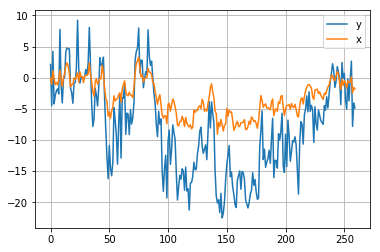

In [12]:
df.plot(grid=True)

Now let's run the regression and form the residuals:

In [13]:
reg = stats.linregress(x,y)
uhat = y - reg.intercept - reg.slope * x

In [14]:
resids = pd.Series(uhat)

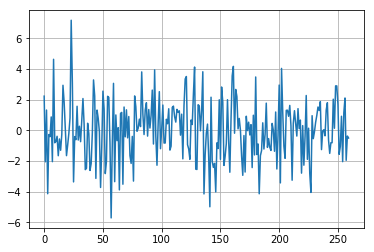

In [15]:
resids.plot(grid=True)

The residuals clearly look to be mean-reverting and stationary. Let's see the results of the ADF test:

In [16]:
results = sm.tsa.stattools.adfuller(uhat)

In [17]:
results

(-12.263731771686777,
 8.957758851089713e-23,
 1,
 258,
 {'1%': -3.455952927706342,
  '5%': -2.8728086526320302,
  '10%': -2.572774990685656},
 1011.0680077636282)

In [18]:
print(f"The ADF test statistic is: {results[0]: 0.4f}, with a p-value of: {results[1] : 0.4f}")

The ADF test statistic is: -12.2637, with a p-value of:  0.0000


That's an awefully small p-value, so we reject the null hypothesis of the ADF test of a unit-root and conclude that $y_{t}$ and $x_{t}$ are cointegrated. Again, we're not surprised since we engineered it. 

## Error-Correction Models

<br>

Whenever two (or more) asset prices are cointegrated, we can also write down an error-correction model. That is, cointegration implies an error-correction form. 

<br>

We state the simplest form of the error-correction model as follows:

$$
\begin{aligned}
\Delta y_{t} &= \lambda (y_{t-1} - \alpha - \beta x_{t-1}) + \nu_{t} \\
\Delta y_{t} &= \lambda (z_{t-1}) + \nu_{t}
\end{aligned}
$$

with $z_{t} = \hat{u}_{t}$.

<br>

This model form relates the changes in $y_{t}$, that is $\Delta y_{t}$ to the ___spread___ between $y_{t-1}$ and $x_{t-1}$ in ___levels___. This is a valid time series regression, given that $\Delta y_{t} \sim I(0)$ via first differencing, and $z_{t-1} \sim I(0)$ via cointegration. 

<br>

Let's see if we can develop some intuition for this model. Let's start by interpreting the coefficient $\lambda$, which we call the ___error-correction coefficient___. Its value will be such that when there is a large past deviation between $y_{t-1}$ and $x_{t-1}$ (i.e. a large error) it will cause an ___error correction___ in the change in $y_{t}$, or $\Delta y_{t}$. In other words, $\Delta y_{t}$ will adjust based on a lagged error in the spread. There is now a stationary relationship (i.e. mean-reverting) that exists, and can even be predicted. It's easy to see now why we call this an error-correction model, and also its relationship with cointegration.

<br>

* __Q:__ What causes the error-correction in $\Delta y_{t}$? 
* __A:__ in financial markets between related asset prices that are cointegrated, the answer is ___arbitrage___!

<br>

We can now think about the error-correction model in terms of some kind of equilibrium concept. When dynamic market forces are such that related asset prices are temporarily driven apart, an arbitrage relationship between the asset prices acts to restore the spread between the two to a long-run equilibrium level. 

<br>

* __Q:__ what kind of equilibrium concept fits this description? 
* __Q:__ is it a static neo-classical equilibrium? 
* __Q:__ is it more like the neo-Austrian type of equilibrium that has been mentioned in this class?

<br>
<br>

### A More General Error-Correction Model

We can also account for possible short-run variation in $\Delta y_{t}$ by adding lagged terms on the right-hand side of the model as follows (as well as a drift term):

$$
\Delta y_{t} = \mu + \sum\limits_{j=1}^{p} \delta_{j} \Delta y_{t-j} + \lambda z_{t-1} + \nu_{t}
$$

<br>


### A Vector Error-Correction Model

Now we can think in terms of systems of equations, and think about a multivariate relationship between $y_{t}$ and $x_{t}$ called a ___vector error-correction model___ (vecm).

<br>

Here is a VECM(1) model in $y_{t}$ and $x_{t}$:

<br>

$$
\begin{aligned}
\Delta y_{t} &= \mu + \delta_{1} \Delta y_{t-1} + \gamma_{1} \Delta x_{t-1} + \lambda_{1} z_{t-1} + \nu_{1,t} \\
\Delta x_{t} &= \mu + \delta_{2} \Delta y_{t-1} + \gamma_{2} \Delta x_{t-1} + \lambda_{2} z_{t-1} + \nu_{2,t}
\end{aligned}
$$

<br>